## Task 1: Created a pandas dataframe, dropped rows with missing titles/descriptions, and then counted the number of tokens.

In [1]:
import os
import pandas as pd
import spacy
from tqdm import tqdm

df = pd.DataFrame()
path_info = './indeed_scraped_data/job_info_data/'

for i in os.listdir(path=path_info):
    if '5222022' in i:
        df_temp = pd.read_csv(os.path.join(path_info, i))
        df_temp = df_temp.rename(columns={'lnks_link':'link',
                               'lnks_job_title':'job_title',
                                'lnks_company':'company',
                                'lnks_company_url':'company_url',
                                'lnks_company_location':'company_location',
                                'lnks_job_description':'job_description'
                               })
        df = pd.concat([df, df_temp])

df.dropna(subset=['job_title','job_description'], inplace=True)

nlp = spacy.load('en_core_web_sm')

tok = {}
for count, i in enumerate(tqdm(df['job_description'])):
    for token in nlp(i):
        tok[token.text] = token.pos_

token_df = pd.DataFrame(columns=['token', 'tag'])
token_df['token'] = tok.keys()
token_df['tag'] = tok.values()

print('number of unique tokens in the job description:', len(tok))
print('the distribution of token tags among them:')
print(token_df['tag'].value_counts())

100%|██████████████████████████████████████████████████████████████████████████████| 4803/4803 [06:17<00:00, 12.72it/s]

number of unique tokens in the job description: 39150
the distribution of token tags among them:
PROPN    15172
NOUN     11187
VERB      4634
ADJ       3294
NUM       3206
ADV        823
X          201
ADP        136
PRON       113
PUNCT       85
SPACE       78
AUX         64
SCONJ       51
DET         42
INTJ        25
CCONJ       18
PART        13
SYM          8
Name: tag, dtype: int64


### 39,150 unique tokens among 4,803 different job descriptions. Highest concentration of proper nouns, followed by nouns and verbs

## Task 2: constructed a dictionary that registers new terms (by unique lemma) and their frequency. That dictionary is saved to a json file and the 10 most common terms are displayed below.

In [2]:
import json
import numpy as np

term = {}
lemma_codex = {}
for count, i in enumerate(tqdm(df['job_description'])):
    for token in nlp(i):
        if not token.is_punct:
            if token.lemma not in lemma_codex.keys():
                term[token.lemma_] = 1
                lemma_codex[token.lemma] = token.lemma_
            else:
                term[lemma_codex[token.lemma]] += 1

with open('job_info_terms.json','w') as f:
    csv_json = json.dump(term, f)

term_df = pd.DataFrame(columns=['term', 'freq'])
term_df['term'] = term.keys()
term_df['freq'] = term.values()

print('number of unique terms in the job description:', len(term))
print('the distribution of terms among them:')
print(term_df.nlargest(10, 'freq'))

100%|██████████████████████████████████████████████████████████████████████████████| 4803/4803 [06:56<00:00, 11.54it/s]


number of unique terms in the job description: 33954
the distribution of terms among them:
     term    freq
8     and  242058
31     \n  227694
42     to  121120
12    the  112072
15     of   98209
6      in   63043
139    be   62358
69   with   51270
19      a   51254
21    for   44857


### Most common 10 terms are articles, conjunctions, 'new lines,' and prepositions

## Bonus task: analyzes entries depending on whether their job title contains certain keywords.

In [3]:
term_wo = {}
term_w = {}
lemma_codex = {}
kws = ["compliance", "regulation", "regulatory"]
pattern = '|'.join(kws)

for i in tqdm(df[df['job_title'].str.contains(pattern, case=False)]['job_description']):
    for token in nlp(i):
        if not token.is_punct:
            if token.lemma not in term_w.keys():
                term_w[token.lemma] = 1
                lemma_codex[token.lemma] = token.lemma_
            else:
                term_w[token.lemma] += 1

for i in tqdm(df[~df['job_title'].str.contains(pattern, case=False)]['job_description']):
    for token in nlp(i):
        if not token.is_punct:
            if token.lemma not in term_wo.keys():
                term_wo[token.lemma] = 1
                if token.lemma not in lemma_codex.keys():
                    lemma_codex[token.lemma] = token.lemma_
            else:
                term_wo[token.lemma] += 1

lemma_df = pd.DataFrame({'lemma': lemma_codex.keys()})
lemma_df['term'] = lemma_df['lemma'].map(lemma_codex)

termw_df = pd.DataFrame(columns=['lemma', 'freq'])
termw_df['lemma'] = term_w.keys()
termw_df['freq'] = term_w.values()
termw_df = lemma_df.merge(termw_df, how="right", on='lemma')

termwo_df = pd.DataFrame(columns=['lemma', 'freq'])
termwo_df['lemma'] = term_wo.keys()
termwo_df['freq'] = term_wo.values()
termwo_df = lemma_df.merge(termwo_df, how="right", on='lemma')

print('JOB TITLES WITH KEYWORDS')
print('number of unique terms in the job description:', len(term_w))
print('the distribution of token tags among them:')
print(termw_df.nlargest(20, 'freq'))

print('\nJOB TITLES WITHOUT KEYWORDS')
print('number of unique terms in the job description:', len(term_wo))
print('the distribution of terms among them:')
print(termwo_df.nlargest(20, 'freq'))

totfreqw = termw_df['freq'].sum()
totfreqwo = termwo_df['freq'].sum()
matchterms = {}

for i in range(len(termw_df)):
    lemmaw = termw_df.loc[i, 'lemma']
    freqw = termw_df.loc[i, 'freq']
    freqw = freqw / totfreqw
    if any(termwo_df['lemma'] == lemmaw):
        tempwo = termwo_df[termwo_df['lemma'] == lemmaw]
        matchterms[lemmaw] = freqw / (tempwo['freq'] / totfreqwo).iloc[0]
    else:
        matchterms[lemmaw] = float('NaN')

mt_df = pd.DataFrame({'lemma': matchterms.keys()})
mt_df['ratio (with-to-without)'] = lemma_df['lemma'].map(matchterms)
mt_df = lemma_df.merge(mt_df, how="right", on='lemma')

100%|██████████████████████████████████████████████████████████████████████████████| 4362/4362 [06:31<00:00, 11.14it/s]


JOB TITLES WITH KEYWORDS
number of unique terms in the job description: 9490
the distribution of token tags among them:
                    lemma        term   freq
18    2283656566040971221         and  18406
3      962983613142996970          \n  17345
47    3791531372978436496          to   9388
5     7425985699627899538         the   8432
21     886050111519832510          of   7263
36   10382539506755952630          be   5098
60    3002984154512732771          in   4733
9    12510949447758279278        with   4311
61   11901859001352538922           a   3919
29   16037325823156266367         for   3540
79    3740602843040177340          or   2591
98   12819252901098364027  compliance   2484
12    7437575085468336610          as   2199
59   10038440415813069799        work   2048
42    9184028488017041184  regulatory   1857
76   12090100147684300169  experience   1663
97    5640369432778651323          on   1610
164  17577015140245084783         our   1505
520  16064069575701507746

<AxesSubplot: ylabel='Density'>

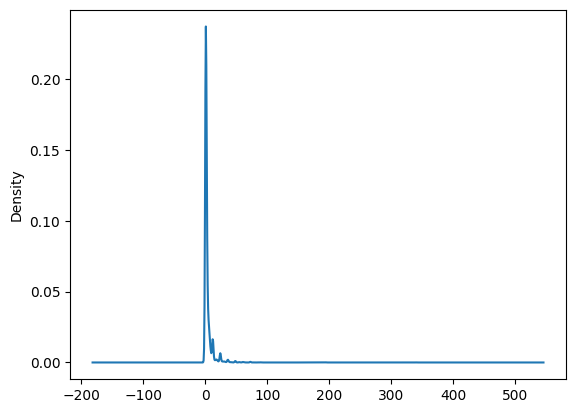

In [4]:
mt_df['ratio (with-to-without)'].plot.kde(bw_method=0.1)

1928    363.932428
1206    339.670266
5306    230.490538
2164    194.097295
2187    194.097295
3419    157.704052
1155    137.485584
1212    121.310809
4857    121.310809
1177    109.179728
Name: ratio (with-to-without), dtype: float64
Median ratio of entries: 1.276955888606812


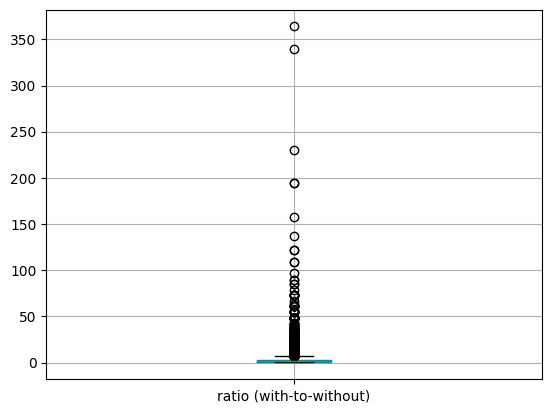

In [5]:
mt_df.boxplot(column=['ratio (with-to-without)'])

print(mt_df['ratio (with-to-without)'].nlargest(10))

print(f"Median ratio of entries: {mt_df['ratio (with-to-without)'].median()}")

### Find that the most common terms are largely the same across the term-frequency dictionaries, excluding the keywords. Looking at the term frequency ratios across the two dictionaries, we find that most terms maintain a relative ratio in the 1-2 range (suggesting some relative parity), but with some notable exceptions that largely only appear in one but not the other (i.e. outlier in the boxplot above).